In [4]:
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import evaluate

In [5]:
dataset = load_dataset("ag_news")

In [6]:
small_train_dataset = dataset['train'].select([i for i in range(5000)])
small_test_dataset = dataset['test'].select([i for i in range(5000)])

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
max_length = 128

In [9]:
def tokenize(batch):
    return tokenizer(batch['text'], padding="max_length", truncation=True, max_length=max_length)

In [10]:
tokenized_train = small_train_dataset.map(tokenize, batched=True)
tokenized_test = small_test_dataset.map(tokenize, batched=True)

In [11]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import TrainingArguments


training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
    gradient_accumulation_steps=4,
    report_to="none",
    dataloader_num_workers=4,
    logging_dir='./logs',
    logging_steps=50,
)

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
accuracy = evaluate.load("accuracy")

In [14]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)  # Get predicted class (highest probability)
    return accuracy.compute(predictions=predictions, references=labels)

In [15]:
trainer = Trainer(
    model=model,                          # The model to train
    args=training_args,                   # The training arguments
    train_dataset=tokenized_train,        # Tokenized training dataset
    eval_dataset=tokenized_test,          # Tokenized validation dataset
    compute_metrics=compute_metrics,      # The metrics to track during training
)

In [16]:
trainer.train()

  0%|          | 0/312 [00:00<?, ?it/s]

{'loss': 0.9437, 'grad_norm': 2.764104127883911, 'learning_rate': 1.6794871794871796e-05, 'epoch': 0.32}
{'loss': 0.4283, 'grad_norm': 4.763635158538818, 'learning_rate': 1.3589743589743592e-05, 'epoch': 0.64}
{'loss': 0.3809, 'grad_norm': 6.437917232513428, 'learning_rate': 1.0384615384615386e-05, 'epoch': 0.96}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.3431397080421448, 'eval_accuracy': 0.8948, 'eval_runtime': 2031.1099, 'eval_samples_per_second': 2.462, 'eval_steps_per_second': 0.308, 'epoch': 1.0}
{'loss': 0.3221, 'grad_norm': 5.269293785095215, 'learning_rate': 7.17948717948718e-06, 'epoch': 1.28}
{'loss': 0.2695, 'grad_norm': 2.977470636367798, 'learning_rate': 3.974358974358974e-06, 'epoch': 1.6}
{'loss': 0.2995, 'grad_norm': 3.598640203475952, 'learning_rate': 7.692307692307694e-07, 'epoch': 1.92}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.3232211172580719, 'eval_accuracy': 0.8976, 'eval_runtime': 707.8592, 'eval_samples_per_second': 7.064, 'eval_steps_per_second': 0.883, 'epoch': 2.0}
{'train_runtime': 9525.2867, 'train_samples_per_second': 1.05, 'train_steps_per_second': 0.033, 'train_loss': 0.43427966573299503, 'epoch': 2.0}


TrainOutput(global_step=312, training_loss=0.43427966573299503, metrics={'train_runtime': 9525.2867, 'train_samples_per_second': 1.05, 'train_steps_per_second': 0.033, 'total_flos': 330650419986432.0, 'train_loss': 0.43427966573299503, 'epoch': 1.9968})

In [17]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

  0%|          | 0/625 [00:00<?, ?it/s]

Evaluation results: {'eval_loss': 0.3232211172580719, 'eval_accuracy': 0.8976, 'eval_runtime': 1621.9311, 'eval_samples_per_second': 3.083, 'eval_steps_per_second': 0.385, 'epoch': 1.9968}


In [18]:
# Example input text for testing
test_text = "Researchers have developed a new form of quantum computer that can perform complex calculations in seconds."

# Step 1: Tokenize the input text
inputs = tokenizer(test_text, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Step 2: Pass the tokenized input to the model
with torch.no_grad():
    outputs = model(**inputs)

# Step 3: Convert logits to predicted probabilities and find the predicted class
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(predictions).item()  # Get the class with the highest probability

# Step 4: Interpret the predicted class
class_labels = ["World", "Sports", "Business", "Science/Technology"]
print(f"Predicted class: {class_labels[predicted_class]}")

Predicted class: Science/Technology


In [19]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

  0%|          | 0/625 [00:00<?, ?it/s]

Evaluation results: {'eval_loss': 0.3232211172580719, 'eval_accuracy': 0.8976, 'eval_runtime': 1014.5317, 'eval_samples_per_second': 4.928, 'eval_steps_per_second': 0.616, 'epoch': 1.9968}


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)
small_test_dataset1 = tokenized_test.select([i for i in range(500)])
predictions = trainer.predict(small_test_dataset1)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = small_test_dataset1['label']

  0%|          | 0/63 [00:00<?, ?it/s]

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score

accuracy = accuracy_score(true_labels, predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(cm)


Accuracy: 0.9
Confusion Matrix:
[[105   7   8   2]
 [  2 142   0   1]
 [  5   0  89  12]
 [  1   1  11 114]]


In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(true_labels, predicted_labels)

cm = confusion_matrix(true_labels, predicted_labels)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(cm)
print(f"Precision (weighted): {precision}")
print(f"Recall (weighted): {recall}")
print(f"F1 Score (weighted): {f1}")

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Accuracy: 0.9
Confusion Matrix:
[[105   7   8   2]
 [  2 142   0   1]
 [  5   0  89  12]
 [  1   1  11 114]]
Precision (weighted): 0.9004278170329209
Recall (weighted): 0.9
F1 Score (weighted): 0.8997841924675863

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       122
           1       0.95      0.98      0.96       145
           2       0.82      0.84      0.83       106
           3       0.88      0.90      0.89       127

    accuracy                           0.90       500
   macro avg       0.90      0.89      0.89       500
weighted avg       0.90      0.90      0.90       500



In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

accuracy = accuracy_score(true_labels, predicted_labels)

cm = confusion_matrix(true_labels, predicted_labels)

precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

performance_matrix = pd.DataFrame({
    "Class": [f"Class {i}" for i in range(len(cm))],
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

performance_matrix.loc['Accuracy'] = ['Accuracy', accuracy, '-', '-']

print(performance_matrix)

print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


             Class  Precision    Recall  F1 Score
0          Class 0   0.929204  0.860656  0.893617
1          Class 1   0.946667   0.97931  0.962712
2          Class 2   0.824074  0.839623  0.831776
3          Class 3   0.883721  0.897638  0.890625
Accuracy  Accuracy   0.900000         -         -
Confusion Matrix:
[[105   7   8   2]
 [  2 142   0   1]
 [  5   0  89  12]
 [  1   1  11 114]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       122
           1       0.95      0.98      0.96       145
           2       0.82      0.84      0.83       106
           3       0.88      0.90      0.89       127

    accuracy                           0.90       500
   macro avg       0.90      0.89      0.89       500
weighted avg       0.90      0.90      0.90       500



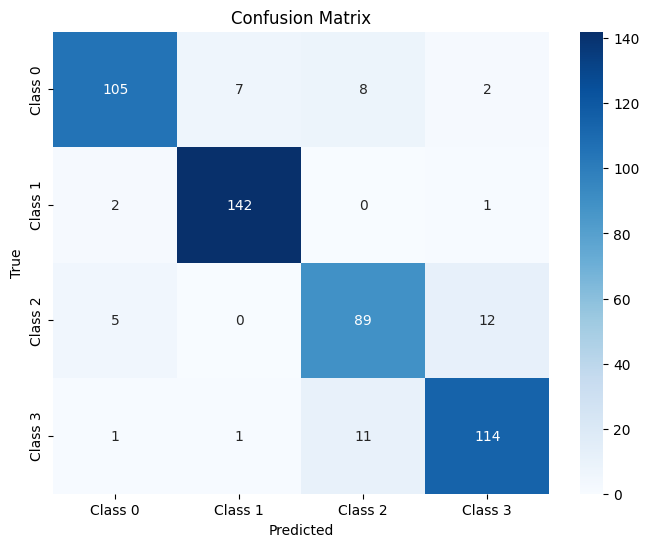

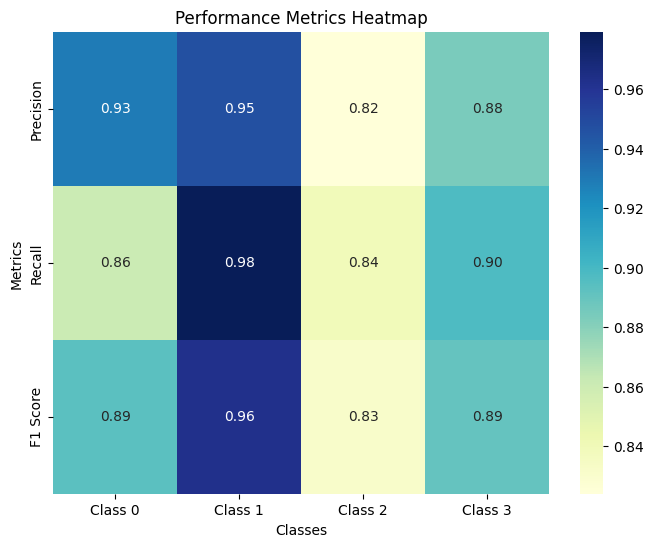

     Class  Precision    Recall  F1 Score
0  Class 0   0.929204  0.860656  0.893617
1  Class 1   0.946667  0.979310  0.962712
2  Class 2   0.824074  0.839623  0.831776
3  Class 3   0.883721  0.897638  0.890625


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd

cm = confusion_matrix(true_labels, predicted_labels)

precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

performance_matrix = pd.DataFrame({
    "Class": [f"Class {i}" for i in range(len(cm))],
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
})

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[f"Class {i}" for i in range(len(cm))], yticklabels=[f"Class {i}" for i in range(len(cm))])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

metrics_matrix = pd.DataFrame([precision, recall, f1], columns=[f"Class {i}" for i in range(len(cm))], index=["Precision", "Recall", "F1 Score"])

plt.figure(figsize=(8, 6))
sns.heatmap(metrics_matrix, annot=True, cmap='YlGnBu', cbar=True, fmt='.2f')
plt.title("Performance Metrics Heatmap")
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.show()

print(performance_matrix)

In [26]:
training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    gradient_accumulation_steps=4,
    report_to="none",
    dataloader_num_workers=4
)



C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
